In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import torch
import torch.nn as nn
import cv2
from glasses.nn.models import *
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from glasses.utils.Storage import ForwardModuleStorage, BackwardModuleStorage
from PIL import Image
from io import BytesIO
import requests
from torchvision.transforms import Normalize

r = requests.get('https://i.insider.com/5df126b679d7570ad2044f3e?width=700&format=jpeg&auto=webp')
im = Image.open(BytesIO(r.content))

In [17]:
class NormalizeInverse(Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.Tensor(mean)
        std = torch.Tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

INFO:root:Loaded resnet18 pretrained weights.


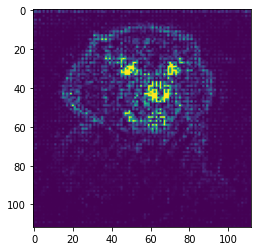

In [22]:
from glasses.interpretability import GradCam, SaliencyMap
cfg = ResNet.configs['resnet18']

transform = cfg.transform
postprocessing = Normalize(-cfg.mean / cfg.std, (1.0 / cfg.std))

x = transform(im).unsqueeze(0)
model = ResNet.resnet18(pretrained=True)

_ = model.interpret(x, using=SaliencyMap()).show()

In [5]:
def tensor2cam(image, cam):
    image_with_heatmap = image2cam(image.permute(1, 2, 0).cpu().numpy(),
                                   cam.detach().cpu().numpy())

    return torch.from_numpy(image_with_heatmap)


def image2cam(image, cam):
    h, w, c = image.shape

    cam -= np.min(cam)
    cam /= np.max(cam)  # Normalize between 0-1
    cam = cv2.resize(cam, (h, w))
    cam = np.uint8(cam * 255.0)

    img_with_cam = cv2.applyColorMap(cam, cv2.COLORMAP_JET)
    img_with_cam = cv2.cvtColor(img_with_cam, cv2.COLOR_BGR2RGB)
    img_with_cam = img_with_cam + (image * 255)
    img_with_cam /= np.max(img_with_cam)

    return img_with_cam

In [6]:
model = ResNet.resnet18(pretrained=True).eval()
conv = model.encoder.blocks[-1].block[-1].block.conv2

weights_storage = ForwardModuleStorage(model, [conv])
gradients_storage = BackwardModuleStorage([conv])

cfg = ResNet.configs['resnet18']

transform = cfg.transform

im_tr = transform(im).unsqueeze(0)

x = Variable(im_tr, requires_grad=True)

out = model(x)

cls = torch.argmax(torch.softmax(out, dim=1))

target = torch.zeros(out.size())
target[0][int(cls)] = 1
        
out.backward(gradient=target, retain_graph=True)

INFO:root:Loaded resnet18 pretrained weights.


In [7]:
from torchvision.transforms import Normalize

class NormalizeInverse(Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.Tensor(mean)
        std = torch.Tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())


In [8]:
weights = weights_storage[conv][0]
grads = gradients_storage[conv][0][0]

post_processing = NormalizeInverse(cfg.mean, cfg.std)

avg_channel_grad = F.adaptive_avg_pool2d(grads.data, 1)
cam = F.relu(torch.sum(weights * avg_channel_grad, dim=1)).squeeze(0)
image_with_heatmap = tensor2cam(post_processing(im_tr).squeeze(0), cam)


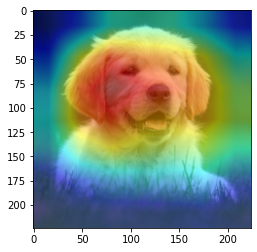

In [9]:
import matplotlib.pyplot as plt


fig = plt.figure()

plt.imshow(image_with_heatmap)

## Get weights

Proposed API

```python
ResNet.resnet50(pretrained=True, dataset='imagenet')

ResNet.pretrained_models
```



In [10]:
from glasses.utils.PretrainedWeightsProvider import PretrainedWeightsProvider
from pathlib import Path

provider = PretrainedWeightsProvider()
for key in provider.weights_zoo.keys():
    provider[key]

INFO:root:Loaded resnet18 pretrained weights.
INFO:root:Loaded resnet26 pretrained weights.
INFO:root:Loaded resnet34 pretrained weights.
INFO:root:Loaded mobilenet_v2 pretrained weights.
INFO:root:Loaded efficientnet_b0 pretrained weights.
INFO:root:Loaded efficientnet_b1 pretrained weights.
INFO:root:Loaded efficientnet_b2 pretrained weights.
INFO:root:Loaded efficientnet_b3 pretrained weights.
INFO:root:Loaded densenet121 pretrained weights.
INFO:root:Loaded densenet169 pretrained weights.
INFO:root:Loaded densenet201 pretrained weights.
INFO:root:Loaded resnet50 pretrained weights.
INFO:root:Loaded cse_resnet50 pretrained weights.
INFO:root:Loaded resnet101 pretrained weights.
INFO:root:Loaded resnet152 pretrained weights.
INFO:root:Loaded resnext50_32x4d pretrained weights.
INFO:root:Loaded resnext101_32x8d pretrained weights.
INFO:root:Loaded wide_resnet50_2 pretrained weights.
INFO:root:Loaded wide_resnet101_2 pretrained weights.
INFO:root:Loaded vgg11 pretrained weights.
INFO:r

In [11]:
from glasses.nn.models import *


# model = ResNetXt.resnext101_32x8d(pretrained=True)

VGG.vgg13(pretrained=True).summary()

INFO:root:Loaded vgg13 pretrained weights.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Conv2dPad-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         Conv2dPad-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
          VGGLayer-6         [-1, 64, 112, 112]               0
         Conv2dPad-7        [-1, 128, 112, 112]          73,856
              ReLU-8        [-1, 128, 112, 112]               0
         Conv2dPad-9        [-1, 128, 112, 112]         147,584
             ReLU-10        [-1, 128, 112, 112]               0
        MaxPool2d-11          [-1, 128, 56, 56]               0
         VGGLayer-12          [-1, 128, 56, 56]               0
        Conv2dPad-13          [-1, 256, 56, 56]         295,168
             ReLU-14          [-1, 256,

(tensor(133047848), tensor(133047848), tensor(507.5373), tensor(719.0525))

In [12]:
import torch
from glasses.nn.models import *
x = torch.rand((1,3,224,224))


FishNet.fishnet99()(x)

tensor([[ 3.9640e-01,  3.3818e-01, -8.0218e-01,  3.4809e-01,  3.6018e-01,
          5.9372e-01,  4.4004e-01, -2.1178e-01,  5.8995e-01, -4.6530e-01,
          4.6797e-01,  4.7280e-01,  6.5241e-01, -1.4157e+00, -4.4501e-01,
          1.2458e+00, -6.6398e-01, -2.9576e-01, -1.1536e-01, -6.2899e-01,
          3.6884e-03,  8.6195e-02, -1.3151e-01,  7.0152e-02, -4.9536e-01,
          5.3976e-01,  1.2405e+00,  5.8948e-01, -6.1174e-01,  3.0310e-01,
          8.0147e-01,  2.7270e-01, -7.0100e-02,  1.6377e-01,  3.3270e-01,
         -1.8421e-02,  2.0359e-01, -3.8076e-01, -3.4862e-01, -1.9024e-01,
          6.6042e-01, -2.5336e-01,  6.2739e-01, -1.2612e-01,  9.9449e-01,
         -1.2007e-01, -7.6869e-01, -8.4417e-03, -3.2568e-01, -9.9457e-02,
          1.3968e+00, -2.3011e-01, -8.2976e-01,  1.2455e+00,  1.0679e+00,
         -5.6556e-01,  7.5729e-01,  4.2892e-02, -1.9756e-01,  5.2604e-01,
         -2.3469e-02, -1.3440e-01,  6.2338e-02, -3.9727e-01, -9.9755e-01,
         -6.0804e-01, -6.9848e-01, -6.

In [13]:
import torch
from glasses.nn.models import *
x = torch.rand((1,3,224,224))


FishNet.fishnet99()(x)

tensor([[-7.9182e-01,  6.2908e-01, -7.6171e-02,  9.6116e-01, -1.7246e-01,
         -7.7504e-01,  4.6063e-01, -4.8376e-01, -3.5269e-01, -1.1006e-01,
         -7.5226e-01, -6.9903e-01,  4.0136e-01,  4.9186e-01,  1.1328e+00,
          6.4798e-02, -8.8069e-02,  4.5461e-01, -3.9345e-01,  1.9413e-01,
         -4.8363e-02, -1.3378e-01,  8.2904e-01, -1.1973e-01,  4.7108e-01,
         -5.1030e-01, -5.2913e-01, -2.5718e-01, -4.2111e-01, -3.6431e-01,
          2.4029e-01,  8.0213e-01,  8.0359e-01,  9.0327e-01,  7.8474e-01,
          2.1061e-01, -1.5013e+00,  3.5530e-01,  7.6950e-01,  4.7179e-01,
         -2.0449e-02, -7.1277e-02, -3.9767e-01, -5.9587e-01,  9.1338e-01,
         -3.2632e-02,  2.7668e-01,  7.1709e-01, -5.0556e-02, -2.8554e-01,
         -4.4777e-01, -6.7673e-01, -9.0804e-02,  1.8396e-01, -1.6899e-01,
         -3.5257e-01, -1.6340e+00, -8.9962e-01,  3.5763e-01, -5.4174e-01,
         -5.3863e-02, -6.6066e-01,  6.3284e-02,  2.3084e-01,  4.1771e-02,
          5.5605e-01,  1.1775e+00, -4.

In [14]:
torch.load('/home/zuppif/Desktop/test.pth')

FileNotFoundError: [Errno 2] No such file or directory: '/home/zuppif/Desktop/test.pth'

In [ ]:
from glasses.nn.blocks import Conv2dPad

x = torch.rand((1,32,9,9))

Conv2dPad(32, 64, kernel_size=9, mode = 'auto', padding=0)

In [ ]:
from glasses.nn.models import *

model =  ResNetXt.resnet18(pretrained=True)

In [ ]:
model.encoder.blocks[-1]

In [ ]:
import timm

timm.list_models('vgg')

In [ ]:
import timm
m = timm.create_model('seresnet101', pretrained=True)
m

In [ ]:
from dataclasses import dataclass
from typing import Tuple, List
from pprint import pprint
from benchmark import benchmark
from glasses.utils.ModuleTransfer import ModuleTransfer
from functools import partial
from glasses.nn.models import *
from torchvision.models import resnet18, resnet34, resnet50, resnet101, resnet152, resnext50_32x4d, resnext101_32x8d, wide_resnet50_2, wide_resnet101_2
from tqdm.autonotebook import tqdm
import torchvision.transforms as T
import torch.nn as nn
import torch
from PIL import Image
from glasses.utils.PretrainedWeightsProvider import Config


models_weights = {
    'seresnet50': Config(),
#     'efficientnet_b4': Config(resize=380, input_size=380, interpolation='bicubic')
}

zoo_models_mapping = {
    'seresnet50': [partial(timm.create_model, 'seresnet101',pretrained=True), SEResNet.cse_resnet34],
   
#   'efficientnet_b4': [partial(timm.create_model, 'tf_efficientnet_b4', pretrained=True), EfficientNet.efficientnet_b4]
}



# pprint(models_weights)

In [ ]:
model

In [ ]:
model = EfficientNetPytorch.from_pretrained('efficientnet-b0')
model.set_swish(False)
summary(model.cuda(), (3, 224, 224))